1. Kompresja obrazów z użyciem sieci neuronowej  

·         Zbiór danych Fashion-MNIST X 

·         Budujemy sieć neuronową dla kompresji danych, a następnie próbujemy sprawdzić czy sieć jest wstanie rozpoznać (poprawnie skwalifikować) dane z dekodera. Proszę również pokazać że sieć do kompresji można „rozciąć” na układ koder-dekoder. X

Tworzymy auto-enkoder i w pierwszej kolejności chcemy pokazać zależność błędu pomiędzy wyjściem a wejściem w stosunku do stopnia kompresji, 

Następnie patrzymy dla jakiś sensownych – wybranych - punktów z powyższej krzywej jak wygląda klasyfikacja danych zakodowanych.        Dla każdego wyniku stosujemy różne miary błędu (ewaluacji) MSE, macierz pomyłek, krzywe ROC, specyficzność czułość, pole pod ROC itp.  

·         Wyniki proszę porównać z istniejącymi w literaturze.  

# Implemntacja 1 enkodera

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
from keras import backend as K
import os
import csv
import random
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


x_train = np.array(x_train).reshape(-1, 28, 28) / 255.0
x_test = np.array(x_test).reshape(-1, 28, 28) / 255.0

# Podział zbioru danych uczących na mniejszy zbiór
x_train, _, y_train_small, _ = train_test_split(x_train, y_train, train_size=0.05, random_state=42)

# Normalizacja danych
x_train = x_train.reshape(-1, 28, 28) / 255.0
x_test = x_test.reshape(-1, 28, 28) / 255.0

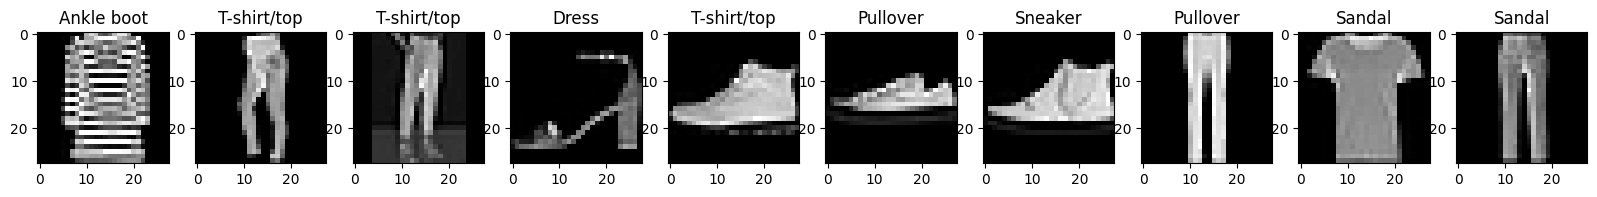

In [13]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])

In [14]:
# Klasa która pozwala tworzyć autoenkoder o wybranym poziomie kompresji 
# compression_level:
# - 1 -> compresion with 1 MaxPooling2D layer 
# - 2 -> compresion with 2 MaxPooling2D layer
# - 3 -> compresion with 2 MaxPooling2D layer and danse layer 
class MaxPooling_autoencoder:
    def __init__(self, x_train, x_test, y_train, y_test, name, compression_level):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.name = name
        self.compression_level = compression_level
        self.input = Input(shape=(28, 28, 1))
        self.model, self.encoder, self.decoder = self.build_model(compression_level)

    def build_model(self, comp_level):
        #building encoder
        inputs = self.input

        if(comp_level == 1): 
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            encoded = BatchNormalization()(x)
            encoder = Model(inputs=inputs, outputs=encoded)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
            decoder = Model(inputs=encoded, outputs=decoded)
            x = encoder(inputs)
            x = decoder(x)

        elif(comp_level == 2):
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
            encoded = BatchNormalization()(x)
            encoder = Model(inputs=inputs, outputs=encoded)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
            x = BatchNormalization()(x)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
            decoder = Model(inputs=encoded, outputs=decoded)
            
        else:
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
            x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
            x = Flatten()(x)
            encoded = Dense(2, activation='relu')(x)
            encoder = Model(inputs=inputs, outputs=encoded)
            encoded_inputs = Input(shape=(2,))
            x = Dense(4, activation='relu')(encoded_inputs)
            x = Reshape((2, 2, 1))(x)
            x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((7, 7))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
            decoder = Model(inputs=encoded_inputs, outputs=decoded)
            x = encoder(inputs)
            x = decoder(x)



        model = Model(inputs=inputs, outputs=x)
        model.compile(optimizer=optimizers.Adam(1e-3), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', 'mse']) ## metryki do ustalenia
        print(model.summary())

        clr = ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=3,
            min_delta=0.01,
            cooldown=0,
            min_lr=1e-7,
            verbose=1)

        model.fit(
            x_train,
            x_train,
            batch_size=256,
            epochs=5,
            shuffle=True,
            validation_data=(x_test, x_test),
            callbacks=[clr])
            
        loss, accuracy, mse = model.evaluate(x_test, x_test)
        print("loss", loss)
        print("accuracy", accuracy)
        print("mse", mse)
                    
        return model, encoder, decoder
        


    def plot_image_reconstructions(self, index):
        # Wybieranie pojedynczego przykładu z danych testowych
        input_image = self.x_test[index]

        # Przekształcanie obrazu przez modele enkodera i dekodera
        encoded_image = self.encoder.predict(np.expand_dims(input_image, axis=0))
        decoded_image = self.decoder.predict(encoded_image)

        # Pobieranie rozmiarów skompresowanych obrazów
        input_shape = input_image.shape[:2]
        encoded_shape = encoded_image.shape[1:]

        # Tworzenie macierzy liczbowej z obrazów
        input_array = input_image.reshape(input_shape)
        encoded_array = encoded_image.reshape(encoded_shape)

        # Wyświetlanie obrazów i macierzy liczbowych
        fig, axs = plt.subplots(2, 3, figsize=(12, 8))

        # Wyświetlanie obrazu przed enkoderem
        axs[0, 0].imshow(input_array, cmap='gray')
        axs[0, 0].set_title('Input Image')
        axs[0, 0].axis('off')

        # Wyświetlanie obrazu po enkoderze
        if self.compression_level == 3:
            axs[0, 1].text(0.5, 0.5, f'[{encoded_array[0]:.2f}, {encoded_array[1]:.2f}]', fontsize=12, ha='center', va='center')
            axs[0, 1].set_title('Encoded Image')
            axs[0, 1].axis('off')
        else:
            axs[0, 1].imshow(encoded_array.squeeze(), cmap='gray')
            axs[0, 1].set_title('Encoded Image')
            axs[0, 1].axis('off')

        # Wyświetlanie obrazu po dekoderze
        axs[0, 2].imshow(decoded_image.squeeze(), cmap='gray')
        axs[0, 2].set_title('Decoded Image')
        axs[0, 2].axis('off')

        # Wyświetlanie macierzy liczbowej po enkoderze
        axs[1, 1].axis('off')  # Pusta osie dla macierzy liczbowej
        axs[1, 1].table(cellText=encoded_array.squeeze(), loc='center', cellLoc='center', bbox=[0, 0, 1, 1])
        axs[1, 1].set_title('Encoded Array')

        # Usunięcie pustych osi
        axs[1, 0].axis('off')
        axs[1, 2].axis('off')

        plt.tight_layout()
        plt.show()


    def apply_autoencoder(self, dataset):
        encoded_dataset = self.encoder.predict(dataset)
        decoded_dataset = self.decoder.predict(encoded_dataset)
        return decoded_dataset



In [15]:
# Tworzenie obiektów dla różnych wartości compression_level
compression_levels = [1,2,3]
autoencoders = []

for level in compression_levels:
    autoencoder = MaxPooling_autoencoder(x_train, x_test, y_train, y_test, f"Autoencoder_Level{level}", level)
    print(f"Working with autoencoder_Level{level}")
    autoencoders.append(autoencoder)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_9 (Functional)        (None, 14, 14, 16)        16896     
                                                                 
 model_10 (Functional)       (None, 28, 28, 1)         19201     
                                                                 
Total params: 36,097
Trainable params: 35,713
Non-trainable params: 384
_________________________________________________________________
None
Epoch 1/5
12/12 [==============================] - 16s 1s/step - loss: 2.9806 - accuracy: 0.3578 - mse: 0.7786 - val_loss: 0.0174 - val_accuracy: 0.4999 - val_mse: 3.1757e-06 - lr: 0.0010
Epoch 2/5
12/12 [==============================] - 16s 1s/step - loss: 2.4748 - accuracy: 0.3951 - mse: 0.6662 - val_loss: 

In [16]:
# Wybieranie losowych indeksów obrazów testowych
num_samples = 10
random_indices = random.sample(range(len(x_test)), num_samples)
# Wywoływanie metody plot_image_reconstructions dla każdego modelu i losowych obrazów
for autoencoder in autoencoders:

     # Tworzenie folderu
    folder_path = f"{autoencoder.name}_autoencoder"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    # Zapisywanie modelu
    print("Saving autoencoder")
    model_path = os.path.join(folder_path, "model.h5")
    autoencoder.model.save(model_path)
        
    print("Saving encoder")
    encoder_path = os.path.join(folder_path, "encoder.h5")
    autoencoder.encoder.save(encoder_path)
        
    print("Saving decoder")
    decoder_path = os.path.join(folder_path, "decoder.h5")
    autoencoder.decoder.save(decoder_path)
        
    # Zapisywanie wyników przebiegu funkcji fit
    history_path = os.path.join(folder_path, "history.csv")
    with open(history_path, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Loss", "Accuracy", "MSE"])
        for i, loss in enumerate(autoencoder.model.history.history['loss']):
            epoch = i + 1
            acc = autoencoder.model.history.history['accuracy'][i]
            mse = autoencoder.model.history.history['mse'][i]
            writer.writerow([epoch, loss, acc, mse])


Saving autoencoder
Saving encoder
Saving decoder
Saving autoencoder
Saving encoder
Saving decoder


KeyError: 'loss'